<font size="6"> Synthetic regression  </font>

In the notebook, we provide the figures and tables for the Meta Learning experiment on a sequence of regression tasks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

from src_icml.simulations import generate_regression_tasks
from src_icml.learners_regression import OGA_reg, mean_OGMS, mean_OPMS, OPMS

# Data

For $t = 1,\ldots,T$, $$y_t = x_t^T \theta_t + \epsilon_t \in \mathbb{R}^n$$

where $\theta_1, \ldots, \theta_T \in \mathbb{R}^d$

**Simulations:**

$$\epsilon_{t,i} \sim \mathcal{U}([-\sigma^2,\sigma^2])$$

$$\theta_t = r u  + \theta_0, u \sim \mathcal{S}^{d-1}, \theta_0 \in \mathbb{R}^d, r \in \mathbb{R}$$
$$x_{t,i} \sim \mathcal{S}^{d-1}$$

In [3]:
T, n, d = 300, 40, 30

# inner-task difficulty (sigma^2)
noise = 0.5

# task similarity (r)
r_l = [0.,5.,10., 30.]
nb_r = len(r_l)

# common bias (theta_0)
mu = np.ones(d)*5

# number of runs (to get confidence intervals)
run = 50

Xs = np.zeros((nb_r,run,T,n,d))
ys = np.zeros((nb_r,run,T,n))
coefs = np.zeros((nb_r, run,T,d))

for i,r in enumerate(r_l):
    for j in range(run):
        Xs[i,j], ys[i,j], coefs[i,j] = generate_regression_tasks(mu = mu,
                                                                 T=T, 
                                                                 n=n,
                                                                 noise=noise,
                                                                 r=r)
        
print(Xs.shape, ys.shape, coefs.shape)

(4, 50, 300, 40, 30) (4, 50, 300, 40) (4, 50, 300, 30)


# Learning in isolation

We compare three methods to learn the tasks in isolation:

- prediction with the true weights for each task theta_t (strong oracle)
- prediction with the common bias theta_0 (weak oracle)
- prediction with the close-form mean squared minimizer: $(X^TX)^{-1}X^Ty$ (batch)
- Online Gradient Descent run independently for each task

## Strong Oracle

In [4]:
mse_oracle = np.zeros((nb_r,run,T))

for i in range(nb_r):
    for r in range(run):
        for t in range(T):

            X,y = Xs[i,r,t], ys[i,r,t]
            y_pred = X.dot(coefs[i,r,t])
            mse = np.mean((y_pred - y)**2)
            mse_oracle[i,r,t] = mse 

## Weak Oracle

In [5]:
mse_oracle_mu = np.zeros((nb_r,run,T))

for i in range(nb_r):
    for r in range(run):
        for t in range(T):

            X,y = Xs[i,r,t], ys[i,r,t]
            y_pred = X.dot(mu)
            mse = np.mean((y_pred - y)**2)
            mse_oracle_mu[i,r,t] = mse 

## Close-form solution (batch)

In [6]:
mse_close = np.zeros((nb_r,run,T))
coefs_close = np.zeros((nb_r,run,T,d))

for i in range(nb_r):
    for r in range(run):
        for t in range(T):
    
            X,y = Xs[i,r,t], ys[i,r,t]
            coef = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
            y_pred = X.dot(coef)
            mse = np.mean((y_pred - y)**2) 
            mse_close[i,r,t] = mse
            coefs_close[i,r,t] = coef

## Online Gradient Descent

In [7]:
%%time

mse_oga_last = np.zeros((nb_r,run,T))  # mse at final weight
losses_oga = np.zeros((nb_r,run,T, n)) # allows to build a regret

for i in range(nb_r):
    for r in range(run):
        for t in range(T):
            
            online_reg = OGA_reg(lr=1./np.sqrt(n))
            X,y = Xs[i,r,t], ys[i,r,t]
            
            y_pred = online_reg.fit_predict(X,y)
            coef = online_reg.coef_
            mse = np.mean((y_pred - y)**2)
            mse_oga_last[i,r,t] = mse
        
            losses_oga[i,r,t] = online_reg.losses_

CPU times: user 20.1 s, sys: 327 ms, total: 20.4 s
Wall time: 19.3 s


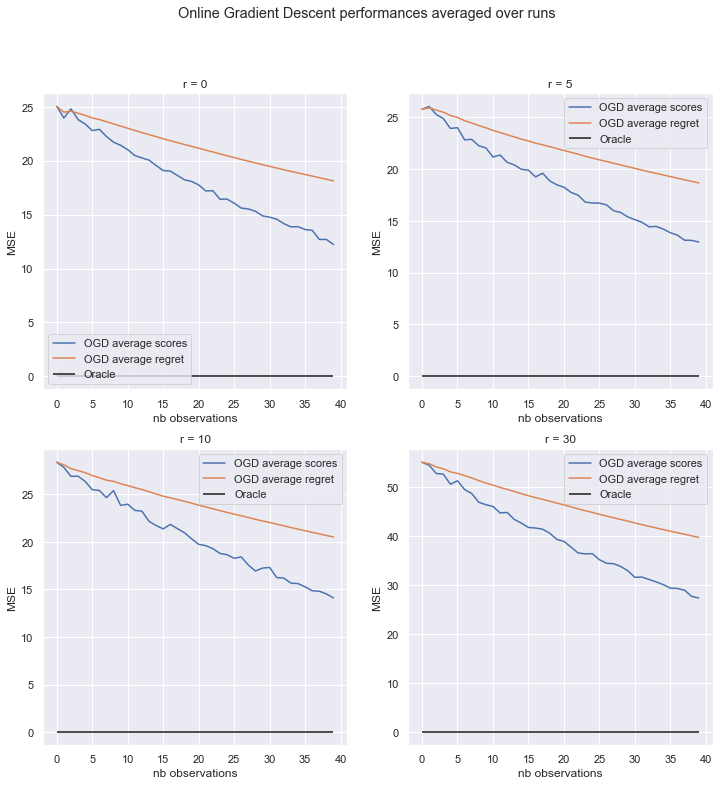

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for i,(r,ax)  in enumerate(zip(r_l,axs.flat)):
    average_loss = losses_oga[i].mean(1).mean(0)

    ax.plot(average_loss,label="OGD average scores")
    ax.plot(np.cumsum(average_loss)/(np.arange(average_loss.shape[0])+1),label="OGD average regret")
    ax.hlines(mse_close[i].mean(),0,average_loss.shape[0]-1, label="Oracle")
    
    ax.set(xlabel="nb observations", ylabel="MSE", title="r = {}".format(int(r)))
    ax.legend()

fig.suptitle("Online Gradient Descent performances averaged over runs")
plt.show()

$n=40$ observations is not enough for Online Gradient Descent to converge, we expect a substantial improvement with meta learning.

# Meta Learning

We test our meta strategies in the linear regression setting. We compare the following methods:

- Idependent Task Learning I-OGA (see above)
- mean OGMS (only learns the starting point)
- mean OPMS (only learns the starting point)
- OPMS (learns the starting point and the learning rate)

## Mean OGMS

Closed-form strategy when we only learn the initialisation point

In [9]:
%%time
meta_weights = np.zeros((nb_r,run,T,d))
save = []

# run meta algo
for i in range(nb_r):
    for r in range(run):
        mean_OGMS_learner = mean_OGMS(lr = 1./np.sqrt(T), gamma=1./np.sqrt(n))
        mean_OGMS_learner.fit(Xs[i,r],ys[i,r])
        meta_weights[i,r] = np.array(mean_OGMS_learner.mu_list_[:-1])
    save.append(mean_OGMS_learner)

CPU times: user 35.1 s, sys: 7.55 s, total: 42.7 s
Wall time: 6.05 s


In [10]:
%%time
# run inner algo on the meta-parameter sequence
mse_mean_ogms = np.zeros((nb_r,run,T))
losses_mean_ogms = np.zeros((nb_r,run, T, n))

for i in range(nb_r):
    for r in range(run):
        for t in range(T):
    
            init = meta_weights[i,r,t]
            online_reg = OGA_reg(lr=1./np.sqrt(n))
            X,y = Xs[i,r,t], ys[i,r,t]
            online_reg.fit(X,y, init=init)
            y_pred = online_reg.predict(X)
            mse = np.mean((y_pred - y)**2)
            mse_mean_ogms[i,r,t] = mse
            losses_mean_ogms[i,r,t] = online_reg.losses_

CPU times: user 20 s, sys: 537 ms, total: 20.5 s
Wall time: 20.4 s


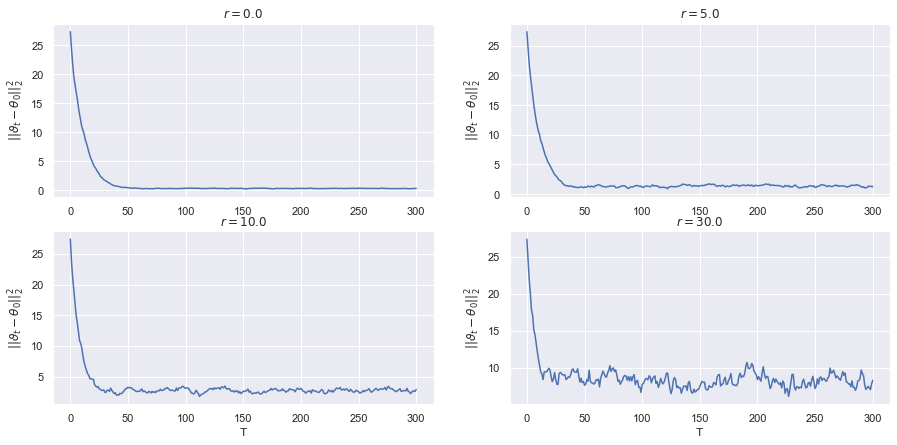

In [11]:
# Display the evolution of the distance between the meta learn parameter 
# and the known common bias theta_0 when we vary the task difficulty (r)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,7))
for i,(r,ax)  in enumerate(zip(r_l,axs.flat)):
    ax.plot(np.linalg.norm(np.array(save[i].mu_list_) - mu.reshape(1,-1),axis=1))
    ax.set_title(r"$r = {}$".format(r))
    ax.set_ylabel(r"$\|\| \vartheta_t - \theta_0 \|\|_2^2$")
    if i>1: ax.set_xlabel("T")
plt.show()

## Mean OPMS

Proximal strategy when we only the initialisation point.

**Inner OGA:** $\ell_{t, i}(\theta)=\left(y_{t, i}-x_{t, i}^{T} \theta\right)^{2}$, $\nabla \ell_{t, i}(\theta)=-2x_{t, i}\left(y_{t, i}-x_{t, i}^{T} \theta\right)$, $\gamma = 1/\sqrt{n}$  $$\theta_{t,i} = \theta_{t,i-1} - \gamma \nabla \ell_{t, i}(\theta_{t,i-1})$$


**Task specific loss:** $$F_t(\theta, \vartheta) = \sum_{i=1}^n \ell_{t,i}(\theta) + B_n(\theta, \vartheta) + \frac{\| \vartheta - \vartheta_{t-1}\|^2}{2 \alpha} = \| y_{t}-X_{t} \theta \|^{2} + \frac{n \gamma \Gamma^2}{2} + \frac{\|\theta - \vartheta\|^2}{2 \gamma} + \frac{\|\vartheta - \vartheta_{t-1}\|^2}{2 \alpha}    $$

**Gradients:**

\begin{aligned}
\frac{\partial F_{t}}{\partial \theta} &=\sum_{i=1}^{n} \nabla \ell_{t, i}(\theta)+\frac{\theta-\vartheta}{\gamma} = -2 X_t^Ty_t+ 2 X_t^TX_t \theta + \frac{\theta-\vartheta}{\gamma}  \\
\frac{\partial F_{t}}{\partial \vartheta} &=\frac{\vartheta-\theta}{\gamma}+\frac{\vartheta-\vartheta_{t-1}}{\alpha}
\end{aligned}

In [12]:
%%time
#run meta algo
meta_weights = np.zeros((nb_r,run,T,d))
save = []

for i in range(nb_r):
    for r in range(run):
        mean_OPMS_learner = mean_OPMS(lr = 1./np.sqrt(T), gamma=1./np.sqrt(n))
        mean_OPMS_learner.fit(Xs[i,r],ys[i,r])
        meta_weights[i,r] = np.array(mean_OPMS_learner.mu_list_[:-1])
    save.append(mean_OPMS_learner)

CPU times: user 2min 28s, sys: 31.8 s, total: 3min
Wall time: 26.2 s


In [13]:
%%time
# run inner algo on the meta-parameter sequence
mse_mean_opms = np.zeros((nb_r,run,T))
losses_mean_opms = np.zeros((nb_r,run, T, n))

for i in range(nb_r):
    for r in range(run):
        for t in range(T):
    
            init = meta_weights[i,r,t]

            online_reg = OGA_reg(lr=1./np.sqrt(n))
            X,y = Xs[i,r,t], ys[i,r,t]
            online_reg.fit(X,y, init=init)
            y_pred = online_reg.predict(X)
            mse = np.mean((y_pred - y)**2)
            mse_mean_opms[i,r,t] = mse
            losses_mean_opms[i,r,t] = online_reg.losses_

CPU times: user 20.1 s, sys: 425 ms, total: 20.6 s
Wall time: 19.8 s


## OPMS

Proximal meta learning strategy to learn both the initialisation point and the learnign rate when OGA is the inner strategy. 

**Task specific loss:** $$F_t(\theta, (\vartheta, \gamma)) = \sum_{i=1}^n \ell_{t,i}(\theta) + B_n(\theta, (\vartheta, \gamma)) + \frac{\| (\vartheta, \gamma) - (\vartheta, \gamma)_{t-1}\|^2}{2 \alpha} = \| y_{t}-X_{t} \theta \|^{2} + \frac{n \gamma \Gamma^2}{2} + \frac{\|\theta - \vartheta\|^2}{2 \gamma} + \frac{\|\vartheta - \vartheta_{t-1}\|^2 + (\gamma - \gamma_{t-1})^2}{2 \alpha}    $$

\begin{aligned}
\frac{\partial F_{t}}{\partial \theta} &=\sum_{i=1}^{n} \nabla \ell_{t, i}(\theta)+\frac{\theta-\vartheta}{\gamma} = -2 X_t^Ty_t+ 2 X_t^TX_t \theta + \frac{\theta-\vartheta}{\gamma} \\
\frac{\partial F_{t}}{\partial \vartheta} &=\frac{\vartheta-\theta}{\gamma}+\frac{\vartheta-\vartheta_{t-1}}{\alpha} \\
\frac{\partial F_{t}}{\partial \gamma} &=\frac{\Gamma^{2} n}{2}-\frac{\|\theta-\vartheta\|^{2}}{2 \gamma^{2}}+\frac{\gamma-\gamma_{t-1}}{\alpha}
\end{aligned}

In [14]:
%%time
#run meta algo
meta_weights = np.zeros((nb_r,run,T,d))
meta_lr = np.zeros((nb_r,run,T))
L_l = [0.5, 2., 5., 50.]
save = []

for i in range(nb_r):
    print(i+1,"/",nb_r)
    for r in range(run):
        OPMS_learner = OPMS(1./np.sqrt(T), L=L_l[i], steps=10, solver="newton")
        OPMS_learner.fit(Xs[i,r],ys[i,r])
        meta_weights[i,r] = np.array(OPMS_learner.mu_list_[:-1])
        meta_lr[i,r] = np.array(OPMS_learner.gamma_list_[:-1])
    save.append(OPMS_learner)

1 / 4
2 / 4
3 / 4
4 / 4
CPU times: user 11min 35s, sys: 2min 31s, total: 14min 7s
Wall time: 1min 57s


In [15]:
%%time
# run inner algo on the meta-parameter sequence
mse_opms = np.zeros((nb_r, run,T))
losses_opms = np.zeros((nb_r, run, T, n))

for i in range(nb_r):
    for r in range(run):
        for t in range(T):
    
            init = meta_weights[i,r,t]
            gamma = meta_lr[i,r,t]

            online_reg = OGA_reg(lr=gamma)
            X,y = Xs[i,r,t], ys[i,r,t]
            online_reg.fit(X,y, init=init)
            y_pred = online_reg.predict(X)
            mse = np.mean((y_pred - y)**2)
            mse_opms[i,r,t] = mse
            losses_opms[i,r,t] = online_reg.losses_

CPU times: user 20.4 s, sys: 523 ms, total: 20.9 s
Wall time: 20.3 s


# Results

See the related paper for an analysis of the results.

In [16]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rcParams.update({'font.size': 40})

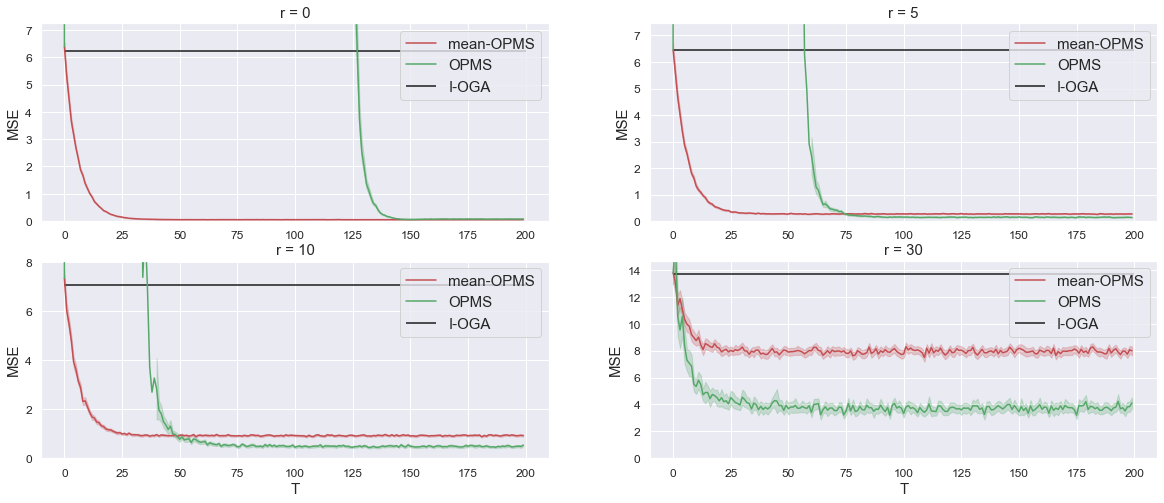

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,8))

CI = [125,60,40,0]
stop = 200
for r, ax in enumerate(axs.flat):
    
    x = mse_mean_opms[r].mean(0)
    ci = 1.96 * np.std(mse_mean_opms[r],0)/np.sqrt(run)
    ax.plot(x[:stop],label="mean-OPMS", color='r')
    ax.fill_between(range(stop),(x-ci)[:stop], (x+ci)[:stop], color='r', alpha=.25)
    
    x = mse_opms[r].mean(0)
    ci = 1.96 * np.std(mse_opms[r],0)/np.sqrt(run)
    ax.plot(x[:stop],label="OPMS", color='g')
    ax.fill_between(range(CI[r],stop),(x-ci)[CI[r]:stop], (x+ci)[CI[r]:stop], color='g', alpha=.25)
    
    oga_itl = mse_oga_last[r].mean(1).mean(0)
    ax.hlines(oga_itl,0,stop, label="I-OGA")
    
    ax.set_ylim(0,oga_itl+1)
    if r>1:
        ax.set(xlabel = "T")
    ax.set_ylabel("MSE")
    ax.set_title("r = {}".format(int(r_l[r])))
    ax.legend()
plt.savefig('regression')
plt.show()

In [18]:
burn = 150
df=pd.DataFrame([mse_oga_last[:,:,burn:200].mean(2).mean(1),
                 mse_mean_opms[:,:,burn:200].mean(2).mean(1),
                 mse_opms[:,:,burn:200].mean(2).mean(1)],
                 columns= ["r="+str(int(r)) for r in r_l],
                 index = ["I-OGA","mean OPMS","OPMS"]
               ).round(decimals=2)
df

r=0   r=5  r=10   r=30
I-OGA      6.23  6.44  7.06  13.67
mean OPMS  0.05  0.27  0.93   7.95
OPMS       0.07  0.14  0.49   3.74